In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import torch, torchvision
import torch.nn as nn
from torch.utils.data import DataLoader

from cubic_subproblem_solver import *

# Helper functions

In [2]:
def get_principal_vecs(X, new_dim):
    assert new_dim <= X.shape[1]
    sigma, V = torch.linalg.eigh(X.T @ X)
    princ_vecs = V[:,-new_dim:]
    # X_reduced = X @ princ_vecs
    return princ_vecs
   
def load_and_transform_mnist(new_dim):
    mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
    mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
    
    X_train = mnist_trainset.data.reshape(-1,28*28) / 255.
    y_train = mnist_trainset.targets
    X_test = mnist_testset.data.reshape(-1,28*28) / 255.
    y_test = mnist_testset.targets
    
    princ_vecs = get_principal_vecs(X_train, new_dim)
    X_train = X_train @ princ_vecs
    X_test = X_test @ princ_vecs
    
    mnist_dataset = {
        "train_data": X_train,
        "train_targets": y_train,
        "test_data": X_test,
        "test_targets": y_test
    }
    
    return mnist_dataset

In [3]:
class LogisticNet(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        return self.linear(x)

def evaluate(model, X, y, criterion):
    with torch.no_grad():
        preds = model(X)
        loss = criterion(preds, y)
        preds = torch.argmax(preds, axis=1)
        acc = torch.mean((preds == y).float())
    return loss.item(), acc.item()

In [42]:
def initialize_metrics(model, dataset, criterion):
    tr_loss, tr_acc = evaluate(model, dataset["train_data"], dataset["train_targets"], criterion)
    tst_loss, tst_acc = evaluate(model, dataset["test_data"], dataset["test_targets"], criterion)
    metrics = {}
    metrics["train_loss"] = [tr_loss]
    metrics["test_loss"] = [tst_loss]
    metrics["train_acc"] = [tr_acc]
    metrics["test_acc"] = [tst_acc]
    metrics["time"] = [0]
    return metrics

def update_metrics(metrics, model, dataset, criterion, epoch_time):
    metrics["time"].append(epoch_time + metrics["time"][-1])
    tr_loss, tr_acc = evaluate(model, dataset["train_data"], dataset["train_targets"], criterion)
    tst_loss, tst_acc = evaluate(model, dataset["test_data"], dataset["test_targets"], criterion)
    metrics["train_loss"].append(tr_loss)
    metrics["test_loss"].append(tst_loss)
    metrics["train_acc"].append(tr_acc)
    metrics["test_acc"].append(tst_acc)

def afterprocess_metrics(metrics, max_time):
    drop_last = (metrics["time"][-1] > max_time)
    for key in metrics.keys():
        if drop_last:
            metrics[key].pop()
        metrics[key] = np.array(metrics[key])
    metrics["epoch"] = np.arange(len(metrics["time"]))

In [43]:
def train_SGD(model, dataset, criterion, optimizer, batch_size, max_epochs=None, max_time=None, print_every=None):
    assert max_epochs != None or max_time != None
    if max_epochs == None:
        max_epochs = torch.inf
    if max_time == None:
        max_time = torch.inf
    metrics = initialize_metrics(model, dataset, criterion)
    if print_every != None:
        print(f'{0: 6,d}: loss = {metrics["train_loss"][-1]: .5f}, time = {metrics["time"][-1]: .2f} sec')
    
    e = 0
    while (e < max_epochs and metrics["time"][-1] < max_time):
        start_time = time.perf_counter()
        for inputs, targets in zip(dataset["train_data"].split(batch_size), dataset["train_targets"].split(batch_size)):
            outputs = model(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        total_time = time.perf_counter() - start_time
        update_metrics(metrics, model, dataset, criterion, total_time)
        if print_every != None and (e+1) % print_every == 0:
            print(f'{e+1: 6,d}: loss = {metrics["train_loss"][-1]: .5f}, time = {metrics["time"][-1]: .2f} sec')
        e += 1
    
    afterprocess_metrics(metrics, max_time)
    return metrics

In [6]:
def calculate_loss(model, X, y, criterion):
    pred = model(X)
    return criterion(pred, y).item()

def calculate_gradient(model, X, y, criterion):
    preds = model(X)
    loss = criterion(preds, y)
    gradients = torch.autograd.grad(loss, model.parameters())
    grad = torch.cat([g.flatten() for g in gradients], dim=0)
    return grad

def calculate_hessian(model, X, y, criterion):
    
    def calculate_loss(*params):
        preds = X @ params[0].T + params[1]
        return criterion(preds, y)
    
    params = tuple([p.data for p in model.parameters()])
    hessians = torch.autograd.functional.hessian(calculate_loss, params)
    hess_1 = torch.cat([hessians[0][0].view(200,200), hessians[0][1].view(200,10)], dim=1)
    hess_2 = torch.cat([hessians[1][0].view(10,200), hessians[1][1]], dim=1)
    hess = torch.cat([hess_1, hess_2], dim=0)
    return hess

def quadratic_form(loss, grad, hess, M, h):
    return loss + torch.dot(grad,h) + 0.5 * torch.dot(hess @ h, h) + M/6 * torch.linalg.norm(h,2)**3

def update_model_params(model, h):
    t = list(torch.split(h, [200, 10]))
    t[0] = t[0].view(10,20)
    for i, p in enumerate(model.parameters()):
        p.data += t[i]

def get_candidate_model(model, h):
    candidate_model = LogisticNet(20,10)
    for p, p_next in zip(model.parameters(), candidate_model.parameters()):
        p_next.data = p.data.clone()
    update_model_params(candidate_model, h)
    return candidate_model

In [44]:
def train_Cubic_Newton(model, dataset, criterion, M_0, max_iters=None, max_time=None, print_every=None):
    assert max_iters != None or max_time != None
    if max_iters == None:
        max_iters = torch.inf
    if max_time == None:
        max_time = torch.inf
    M = M_0
    metrics = initialize_metrics(model, dataset, criterion)
    if print_every != None:
        print(f'{0: 4,d}: loss = {metrics["train_loss"][-1]: .5f}, M = {M}, time = {metrics["time"][-1]: .2f} sec')

    i = 0
    while (i < max_iters and metrics["time"][-1] < max_time):
        start_time = time.perf_counter()
        loss = calculate_loss(model, dataset["train_data"], dataset["train_targets"], criterion)
        grad = calculate_gradient(model, dataset["train_data"], dataset["train_targets"], criterion)
        hess = calculate_hessian(model, dataset["train_data"], dataset["train_targets"], criterion)
        h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), M))
        candidate_model = get_candidate_model(model, h)

        while (calculate_loss(candidate_model, dataset["train_data"], dataset["train_targets"], criterion) > 
               quadratic_form(loss, grad, hess, M, h)):
            M *= 2
            h = torch.tensor(cubic_subproblem_solver(grad.numpy(), hess.numpy(), M))
            candidate_model = get_candidate_model(model, h)

        update_model_params(model, h)
        M /= 2
        total_time = time.perf_counter() - start_time
        update_metrics(metrics, model, dataset, criterion, total_time)
        if print_every != None and (i+1) % print_every == 0:
            print(f'{i+1: 4,d}: loss = {metrics["train_loss"][-1]: .5f}, M = {M}, time = {metrics["time"][-1]: .2f} sec')
        i += 1
    
    afterprocess_metrics(metrics, max_time)
    return metrics

# Hyperparameters tuning for GD and SGD

In [67]:
def hyperparams_tuning(lrs, momentums, epochs, batch_size):
    params = []
    res = []
    for lr in lrs:
        for momentum in momentums:
            model = LogisticNet(20,10)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            criterion = nn.CrossEntropyLoss()
            train_loss, test_loss, train_acc, test_acc, training_time = train_SGD(
                model, optimizer, criterion, batch_size, max_epochs=epochs)
            params.append({'lr': lr, 'mom': momentum})
            res.append(test_loss)
    return params, res

### SGD

In [95]:
for p, tst_loss in zip(params, res):
    if p["mom"] == 0.0:
        print(f'lr: {p["lr"]: .4f}, mom: {[p["mom"]]} test loss = {tst_loss[-1]: .5f}')

lr:  0.0300, mom: [0.0] test loss =  0.39606
lr:  0.0100, mom: [0.0] test loss =  0.39521


best lr = 0.01

### GD

In [92]:
for p, tst_loss in zip(params, res):
    print(f'lr: {p["lr"]: .4f}, mom: {[p["mom"]]} test loss = {tst_loss[-1]: .5f}')

lr:  1.0000, mom: [0.0] test loss =  0.39534
lr:  0.3000, mom: [0.0] test loss =  0.39501


best lr = 0.3

# Experiments

In [45]:
new_dim = 20

mnist_dataset = load_and_transform_mnist(new_dim)

In [46]:
try:
    with open("./data/const_stepsize_results_not_existing", "rb") as file:
        results =  pickle.load(file)
except:
    results = {}
    max_time = 5 # (in seconds)
    criterion = nn.CrossEntropyLoss()

    # SGD
    model = LogisticNet(20,10)
    lr = 1e-2
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    batch_size = 128

    print('TRAIN SGD')
    results["SGD"] = train_SGD(model, mnist_dataset, criterion, optimizer, batch_size, max_time=max_time, print_every=10)
    print()

    # GD
    model = LogisticNet(20,10)
    lr = 3e-1
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    batch_size = 60000 # whole dataset

    print('TRAIN GD')
    results["GD"] = train_SGD(model, mnist_dataset, criterion, optimizer, batch_size, max_time=max_time, print_every=50)
    print()

    # Cubic Newton
    model = LogisticNet(20,10)
    M_0 = 0.01

    print('TRAIN CUBIC_NEWTON')
    results["Cubic Newton"] = train_Cubic_Newton(model, mnist_dataset, criterion, M_0, max_time=max_time, print_every=1)
    print()
    
    with open("./data/const_stepsize_results", "wb") as file:
        pickle.dump(results, file)

TRAIN SGD
     0: loss =  2.85353, time =  0.00 sec
    10: loss =  0.48119, time =  1.69 sec
    20: loss =  0.44800, time =  3.26 sec
    30: loss =  0.43588, time =  5.01 sec

TRAIN GD
     0: loss =  2.94615, time =  0.00 sec
    50: loss =  0.59936, time =  0.83 sec
   100: loss =  0.51622, time =  1.68 sec
   150: loss =  0.48467, time =  2.52 sec
   200: loss =  0.46771, time =  3.39 sec
   250: loss =  0.45705, time =  4.21 sec

TRAIN CUBIC_NEWTON
   0: loss =  3.18650, M = 0.01, time =  0.00 sec
   1: loss =  1.32488, M = 0.16, time =  4.52 sec
   2: loss =  0.77694, M = 0.08, time =  9.78 sec



In [39]:
def draw(ax, results, x_label, y_label, ylim=None):
    ax.plot(results["SGD"][x_label], results["SGD"][y_label], label='SGD')
    ax.plot(results["GD"][x_label], results["GD"][y_label], label='GD')
    ax.plot(results["Cubic Newton"][x_label], results["Cubic Newton"][y_label], label='Cubic Newton')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_yscale('log')
    if ylim != None:
        ax.set_ylim(ylim)
    ax.legend()

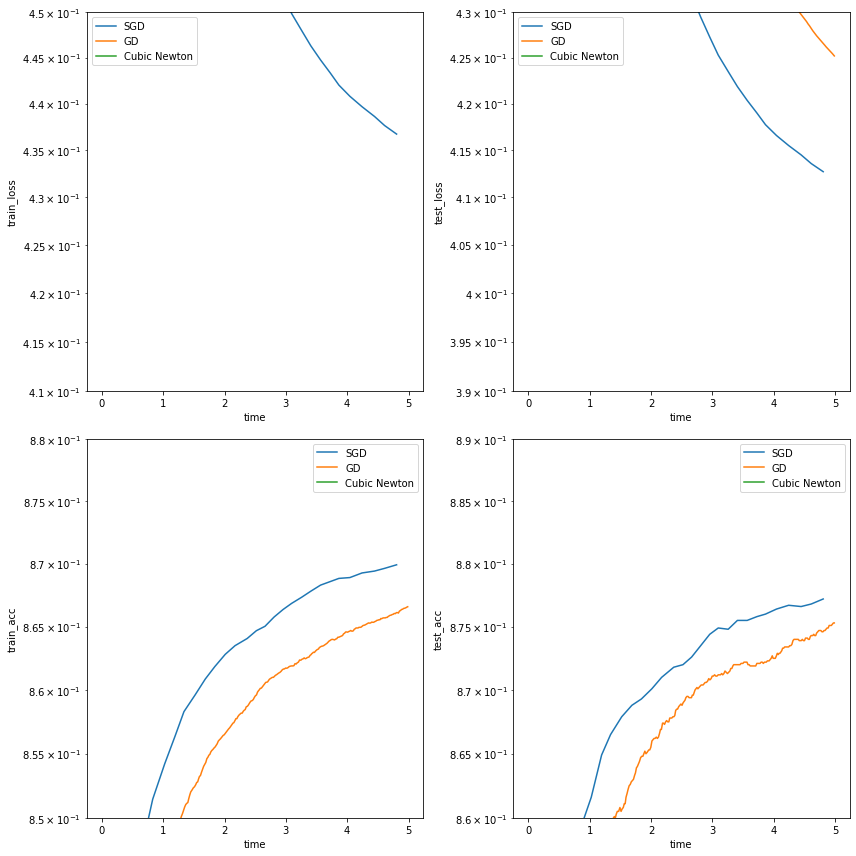

In [47]:
fig, axes = plt.subplots(2,2, figsize=(12,12))

draw(axes[0,0], results, "time", "train_loss", ylim=[0.41, 0.45])
draw(axes[0,1], results, "time", "test_loss", ylim=[0.39, 0.43])
draw(axes[1,0], results, "time", "train_acc", ylim=[0.85, 0.88])
draw(axes[1,1], results, "time", "test_acc", ylim=[0.86, 0.89])

fig.tight_layout()
plt.show()

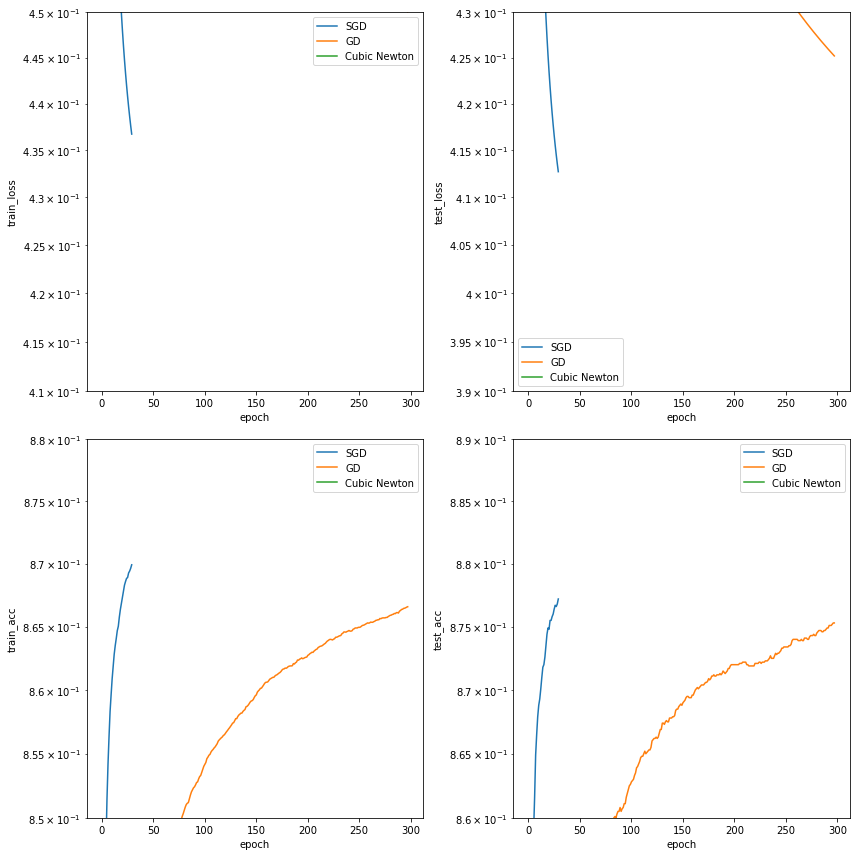

In [48]:
fig, axes = plt.subplots(2,2, figsize=(12,12))

draw(axes[0,0], results, "epoch", "train_loss", ylim=[0.41, 0.45])
draw(axes[0,1], results, "epoch", "test_loss", ylim=[0.39, 0.43])
draw(axes[1,0], results, "epoch", "train_acc", ylim=[0.85, 0.88])
draw(axes[1,1], results, "epoch", "test_acc", ylim=[0.86, 0.89])

fig.tight_layout()
plt.show()

In [42]:
print('Final TRAIN LOSS')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {train_loss[method][-1]: .5f}')
print()

print('Final TEST LOSS')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {test_loss[method][-1]: .5f}')
print()

print('Final TRAIN ACCURACY')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {train_acc[method][-1]: .5f}')
print()

print('Final TEST ACCURACY')
for method in ["SGD", "GD", "Cubic Newton"]:
    print(f'{method: >12}: {test_acc[method][-1]: .5f}')
print()

Final TRAIN LOSS
         SGD:  0.41548
          GD:  0.41567
Cubic Newton:  0.41536

Final TEST LOSS
         SGD:  0.39528
          GD:  0.39502
Cubic Newton:  0.39550

Final TRAIN ACCURACY
         SGD:  0.87513
          GD:  0.87512
Cubic Newton:  0.87523

Final TEST ACCURACY
         SGD:  0.88070
          GD:  0.87990
Cubic Newton:  0.88080

